## 1. Set up

### 1) Install additional packages required to run the code

In [1]:
qui ssc install reghdfe , replace
qui ssc install ftools  , replace // needed for reghdfe to work

### 2) Load the data

In [2]:
use "https://raw.githubusercontent.com/worldbank/Stata-IE-Visual-Library/develop/Library/Bar%20plots/Bar%20plots%20of%20multiple%20variables%20with%20treatment%20effect%20confidence%20intervals%2C%20statistical%20significance%20and%20percentage%20change/data.dta", clear

(Student Test Scores)


### 3) Drop all existing matrices

In [3]:
cap mat drop _all                 //otherwise, 'nullmat' will not work

## 2. Store Results

### 1) Store control means

In [4]:
foreach subject in math reading human_sci natural_sci average {
    qui sum student_`subject' if school_treated == 0
    scalar     mean_`subject' = r(mean)
    mat        mean_control   = nullmat(mean_control) \ mean_`subject'  
}

### 2) Estimate treatment effect

In [5]:
foreach subject in math reading human_sci natural_sci average {
    qui reghdfe student_`subject' school_treated, ///
        abs(school_strata) cl(school_id)

            mat results = r(table) // Store regression table

            mat beta    = nullmat(beta)    \  _b[school_treated] 
            mat beta_se = nullmat(beta_se) \ _se[school_treated] // Store treatment effect coefficient and standard error

            mat pvalue_aux = results[4,1]
            mat pvalue     = nullmat(pvalue)  \ pvalue_aux       // Retrieve p-values from regression table and store them
}

## 3. Prepare the Data

### 1) Remove data from memory

In [6]:
clear

### 2) Set outcome variables

In [7]:
set obs 5

gen         dep_var = ""
qui replace dep_var = "Math"            in 1
qui replace dep_var = "Reading"         in 2 
qui replace dep_var = "Human Science"   in 3
qui replace dep_var = "Natural Science" in 4
qui replace dep_var = "Average"         in 5 


number of observations (_N) was 0, now 5

(5 missing values generated)







### 3) Import results from matrices

In [8]:
svmat beta
svmat beta_se
svmat pvalue
svmat mean_control

### 4) Rename all new variables

In [9]:
rename *1 *

### 5) Expand data to allow for control and treatment arms

In [10]:
expand 2, gen(treatment)

(5 observations created)


### 6) Define outcome variable

In [11]:
gen     y = mean_control if !treatment
replace y = mean_control + beta if  treatment


(5 missing values generated)

(5 real changes made)


### 7) Generate high and low points for standard error bars

In [12]:
gen hiy  = y + 1.65 * beta_se if  treatment
gen lowy = y - 1.65 * beta_se if  treatment


(5 missing values generated)

(5 missing values generated)


### 8) Transform coefficient in string with two decimals + add stars

In [13]:
gen coefficient_str = ""
replace coefficient_str = string(round(beta,.01), "%9.2f") + "*"   if pvalue>0.05 & pvalue<=0.10
replace coefficient_str = string(round(beta,.01), "%9.2f") + "**"  if pvalue>0.01 & pvalue<=0.05
replace coefficient_str = string(round(beta,.01), "%9.2f") + "***" if pvalue<=0.01


(10 missing values generated)

variable coefficient_str was str1 now str5
(2 real changes made)

variable coefficient_str was str5 now str6
(8 real changes made)

(0 real changes made)


### 9) Calculate percentage change and save it in string variable

In [14]:
qui gen pct_change     = beta / mean_control * 100 if pvalue<=0.10
qui gen pct_change_str = string(round(pct_change,.01), "%9.2f") + "%" if pvalue<=0.10

### 10) Concatenate coefficient and percentange change (only when there is a significant effect)

In [15]:
gen effect_lab     = coefficient_str + ": +" + pct_change_str if  pct_change>0 & !mi(pct_change)
replace effect_lab = coefficient_str + ": -" + pct_change_str if  pct_change<0 & !mi(pct_change)



(0 real changes made)


### 11) Specify bars and label positioning

In [16]:
qui gen bar_position     = treatment + 0.5  if  dep_var == "Math"

qui replace bar_position = treatment + 4.5  if  dep_var == "Reading"
qui replace bar_position = treatment + 8.5  if  dep_var == "Human Science"
qui replace bar_position = treatment + 12.5 if  dep_var == "Natural Science"
qui replace bar_position = treatment + 16.5 if  dep_var == "Average"

qui gen effect_position  = bar_position + 0.5 if  treatment


## 4. Plot the Graph

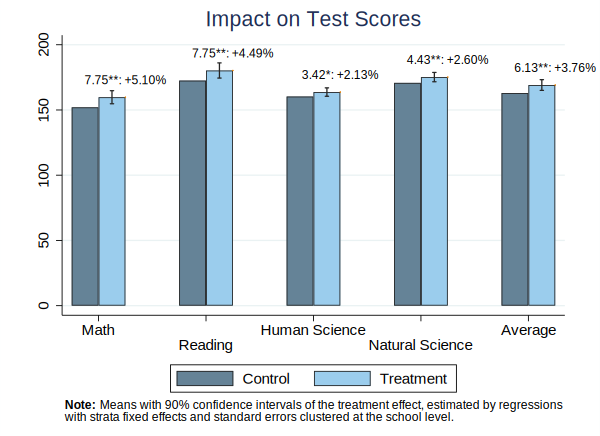

In [17]:
gr tw ( bar y bar_position if !treatment , color(edkblue)   lcolor(black*0.85) ) ///
      ( bar y bar_position if  treatment , color(eltblue)   lcolor(black*0.85) ) ///
            ( rcap hiy lowy bar_position, msize(.75) lcolor(black*0.85) ) ///
            ( scatter y effect_position, msize(zero) ///
                                         mlab(effect_lab) ///
                                         mlabpos(12) mlabgap(3)  ///
                                         mlabcolor(black) mlabsize(small)    ), ///
            title("Impact on Test Scores") ///
            ytitle("") ///
            xtitle("")  ///
            yscale(range(0 200)) ///
            ylab(0(50)200)  ///
            xlab(1 "Math" 5 "Reading" 9 "Human Science" 13 "Natural Science" 17 "Average", alt) ///
            legend(order (1 "Control" 2 "Treatment"))   ///
            note("{bf:Note:} Means with 90% confidence intervals of the treatment effect, estimated by regressions" ///
                                "with strata fixed effects and standard errors clustered at the school level.")  ///
            graphregion(color(white)) ///
            graphregion(margin(8 8 2 2))

## 5. Export the Graph

In [ ]:
qui graph export "figure.png", width(5000) as(png) replace